Dieses Notebook erzeugt Diagramme, welche helfen sollen, die Herleitung der SR-EELS Korrektur nachzuvollziehen.

In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from matplotlib import cm
import matplotlib.image as mpimg
%matplotlib inline
import scipy.optimize
import numpy as np
from numpy.polynomial import polynomial
import math

Der verwendete Datensatz wurde mit den Parametern SpecMag = 315x und QSinK7 = 0% aufgenommen. Enthalten sind 8 SR-EEL Spektren.

In [2]:
def read_data(path):
    """There are several csv files in path that get combined.
    Additionally a list of the single datasets is returned.
    """
    import os
    dfs = []
    for file in os.listdir(path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(path, file), sep=';')
            df['File'] = file
            dfs.append(df)
    return pd.concat(dfs), dfs


def get_filename(file):
    return file['x-position'][0]


data, files = read_data('data/characterisation_Li,32,poly3/SM315/0/20131028/Li,32,64,64,poly3')
files = sorted(files, key=get_filename)

colors = plt.get_cmap('Vega20b')

Zuerst werden zu jedem Spektrum 3 Polynome bestimmt. Diese Polynome beschreiben den Verlauf der Ränder ('left-position', 'right-position') und des Zentrums ('x-position').

Die Parameter der einzelnen Polynome werden den einzelnen DataFrames hinzugefügt, damit wir diese zum Plotten verwenden können.

Außerdem wird jeweils der Schnittpunkt der Polynome mit der y-Achse als neue Spalte zu den DataFrames hinzugefügt. Für die Bestimmung der Funktionenschar dienen diese neuen Werte als $x_2$-Werte. In meiner Dissertation verwende ich die Bezeichnung $y_o$.

In [3]:
def fit_polynomials(df):
    fits = []
    for date in ('x-position', 'left-position', 'right-position'):
        popt = polynomial.polyfit(x=df['y-position'], y=df[date], deg=3)
        fits.append(popt)
        df[date + '0'] = polynomial.polyval(0, popt)
    return fits


for file in files:
    file.popts = fit_polynomials(file)

``data`` wird durch den erweiterten Datensatz ersetzt. Außerdem werden Listen mit den Datenpunkten erstellt, die später im Scatter-Plot dargestellt werden sollen. Diese Daten dienen auch als Grundlage für die Bestimmung der Funktionenschar (als 2D-Polynom).

In [4]:
dfs = []
for file in files:
    dfs.append(file)
data = pd.concat(dfs)

data_x1 = []
data_x2 = []
data_y = []
for date in ('x-position', 'left-position', 'right-position'):
    for x1, x2, y in zip(data['y-position'], data[date + '0'], data[date]):
        data_x1.append(x1)
        data_x2.append(x2)
        data_y.append(y)

Das Diagramm zeigt nur die Datenpunkte für das Zentrum der Spektren. Außerdem wird nur jeder 4te Datenpunkt angezeigt. Als Kurve ist ist das Polynom 3ten Grades zu sehen, welches zuvor bestimmt wurde. Durch Rauten sind die Schnittpukte mit der y-Achse markiert.

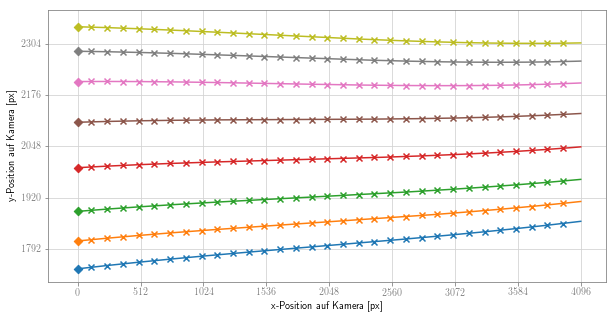

In [5]:
plt.figure(figsize=(10,5))
norm = mpl.colors.Normalize(vmin=0, vmax=len(files))
c_scale = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Vega10).to_rgba
for j, file in enumerate(files):
    for i, date in enumerate(('x-position',)):
        plt.scatter(file['y-position'][1::4], file[date][1::4], c=c_scale(j), marker='x', linewidths=0.2)
        x_fit = np.linspace(0, 4095, 1000)
        y_fit = polynomial.polyval(x_fit, file.popts[i])
        plt.plot(x_fit, y_fit, c=c_scale(j))
        for val in set(file[date + '0']):
            plt.scatter(0, val, c=c_scale(j), marker='D', zorder=10)
plt.xticks(range(0, 4097, 512))
plt.xlabel('x-Position auf Kamera [px]')
plt.yticks(range(1792, 2305, 128))
plt.ylabel('y-Position auf Kamera [px]')
plt.savefig('Bilder/SR-EELS_Korrektur_Polynome_Position')
plt.show()

Hier wird überprüft, ob die Schnittpunkte mit der y-Achse als zusätzliche Spalten hinzugefügt wurden. Dazu muss nach rechts gescrollt werden.

In [6]:
files[0].head()

,y-position,y-error,x-position,x-error,left-position,left-error,right-position,right-error,width,width-error,threshold,fitted-x-position,fitted-left-position,fitted-right-position,File,x-position0,left-position0,right-position0
0,79.864525,0.0,1745.424805,0.0,1649.0,0.0,1846.0,0.0,197.0,0.0,0.0,1745.576504,1649.134557,1845.483233,Cal_01.csv,1742.769188,1645.692346,1843.265528
1,111.863129,0.0,1746.579102,0.0,1650.0,0.0,1847.0,0.0,197.0,0.0,0.0,1746.683017,1650.493386,1846.354058,Cal_01.csv,1742.769188,1645.692346,1843.265528
2,143.868011,0.0,1747.663208,0.0,1652.0,0.0,1844.0,0.0,192.0,0.0,0.0,1747.779571,1651.841122,1847.215146,Cal_01.csv,1742.769188,1645.692346,1843.265528
3,175.868134,0.0,1748.787964,0.0,1653.0,0.0,1848.0,0.0,195.0,0.0,0.0,1748.865963,1653.177495,1848.066374,Cal_01.csv,1742.769188,1645.692346,1843.265528
4,207.870773,0.0,1749.864868,0.0,1654.0,0.0,1849.0,0.0,195.0,0.0,0.0,1749.942616,1654.503002,1848.908111,Cal_01.csv,1742.769188,1645.692346,1843.265528


Das folgende Diagramm zeigt den Datensatz, welcher zur Bestimmung der Funktionenschar genutzt wird.

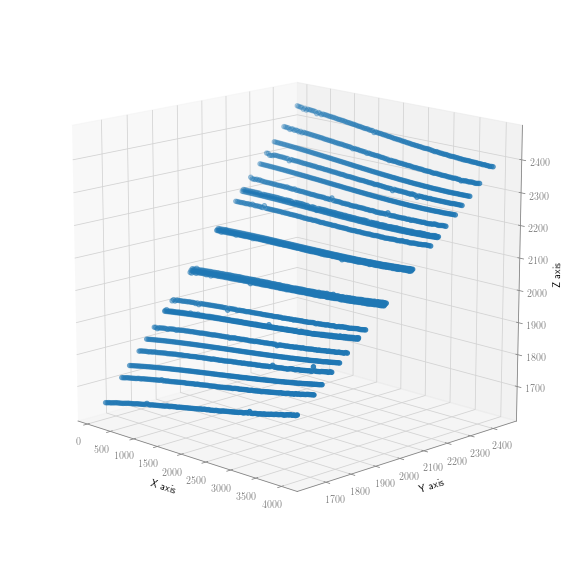

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection = '3d')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

ax.scatter(data_x1, data_x2, data_y)
ax.view_init(elev=15, azim=-45)
plt.show()

An dieser Stelle wird die Funktionenschar bestimmt. Da es sich um ein 2D-Polynom habdelt, kann deises mit Hilfe von Numpy bestimmt werden. Die Implementierung ist etwas komplizierter, als im 1D-Fall, weshalb auf Code zurückgegriffen werden muss, der auf stackoverflow zu finden ist.

Um den Fit optimal zu bestimmen, werden die Datenpunkte um 2048 Pixel verschoben. Dadurch sind diese in etwa um den Ursprung des Koordinatensystems zentriert.

Beim Berechenen der Funktionswerte muss diese Verschiebung auch berücksichtigt werden, wozu die Funktion ``polyval2d`` dient.

Bei dem Fit der Spektrumsbreite werden nur die x- und y- Koordinaten verschoben. Dies wird durch einen optinalen Parameter der beiden Funktionen gesteuert.

In [8]:
def polyfit2d(x, y, f, deg, fit_w=False):
    ''' siehe http://stackoverflow.com/questions/7997152/python-3d-polynomial-surface-fit-order-dependent
    '''
    x = np.asarray(x)
    y = np.asarray(y)
    f = np.asarray(f)
    if not fit_w:
        f -=  2048
    deg = np.asarray(deg)
    vander = polynomial.polyvander2d(x - 2048, y - 2048, deg)
    # reshape ist nur notwendig, wenn die Daten noch nicht die passende Form besitzen:
    #vander = vander.reshape((-1,vander.shape[-1]))
    #f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

def polyval2d(x, y, p, calc_w=False):
    x = np.asarray(x)
    y = np.asarray(y)
    val =  polynomial.polyval2d(x - 2048, y - 2048, p)
    if calc_w:
        return val
    else:
        return val + 2048

popt22 = polyfit2d(data_x1, data_x2, data_y, (2, 2))
popt23 = polyfit2d(data_x1, data_x2, data_y, (2, 3))
popt32 = polyfit2d(data_x1, data_x2, data_y, (3, 2))
popt33 = polyfit2d(data_x1, data_x2, data_y, (3, 3))
popt22, popt23

(array([[  1.51290409e+01,   8.59753610e-01,   3.86744061e-06],
        [  7.51896739e-03,  -6.45836149e-05,   1.05221295e-09],
        [  9.16758681e-07,   2.08841075e-09,   1.28674849e-13]]),
 array([[  1.51296616e+01,   8.61032650e-01,   3.81420675e-06,
          -1.34318649e-08],
        [  7.51977504e-03,  -6.29528841e-05,   9.85116399e-10,
          -1.70521754e-11],
        [  9.17047472e-07,   2.68892611e-09,   1.04527498e-13,
          -6.32827124e-15]]))

Das folgende Diagramm zeigt, wie stark sich die Polynome der Grade (2, 2) und (2, 3) voneinander unterscheiden.

Bei dem Verwendeten Datensatz ist der Unterschied sehr gering.

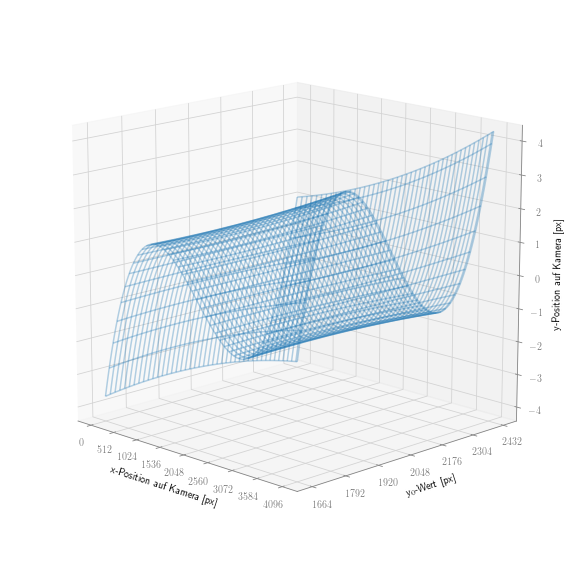

In [9]:
xs = np.linspace(0, 4097, 128)
ys = np.linspace(1792-128, 2305+128, 128)
Xs, Ys = np.meshgrid(xs, ys)

Zs = polyval2d(Xs, Ys, popt32) - polyval2d(Xs, Ys, popt22)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection = '3d')

ax.set_xlabel('x-Position auf Kamera [px]')
ax.set_xticks(range(0, 4097, 512))
ax.set_ylabel('y$_0$-Wert [px]')
ax.set_yticks(range(1792-128, 2305+128, 128))
ax.set_zlabel('y-Position auf Kamera [px]')
#ax.set_zticks(range(1792-128, 2305+128, 128))

ax.plot_wireframe(Xs, Ys, Zs, alpha=0.33)
ax.view_init(elev=15, azim=-45)
plt.show()

Das nächste Diagramm zeigt alle für den Fit verwendeten Datenpunkte und wie gut diese mit dem Fit übereinstimmen.

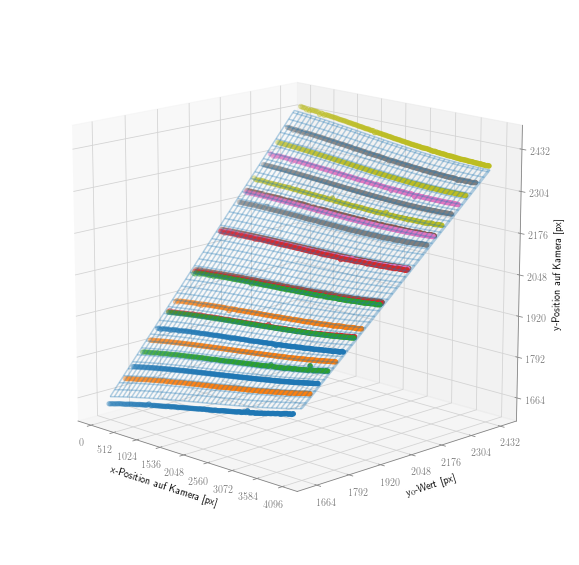

In [10]:
Zs = polyval2d(Xs, Ys, popt32)

fig = plt.figure(figsize=(10,10))
norm = mpl.colors.Normalize(vmin=0, vmax=len(files))
c_scale = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Vega10).to_rgba
ax = fig.gca(projection = '3d')

ax.set_xlabel('x-Position auf Kamera [px]')
ax.set_xticks(range(0, 4097, 512))
ax.set_ylabel('y$_0$-Wert [px]')
ax.set_yticks(range(1792-128, 2305+128, 128))
ax.set_zlabel('y-Position auf Kamera [px]')
ax.set_zticks(range(1792-128, 2305+128, 128))

ax.plot_wireframe(Xs, Ys, Zs, alpha=0.33)
for i, file in enumerate(files):
    for date in ('x-position', 'left-position', 'right-position'):
        ax.scatter(file['y-position'], file[date + '0'], file[date], c=c_scale(i))
ax.view_init(elev=15, azim=-45)
plt.savefig('Bilder/SR-EELS_Korrektur_Polynom2D_Position_3D')
plt.show()

Mit dem Folgenden Diagramm soll gezeigt werden, dass die gewählte Funktionenschar die beste Übereinstimmung ergibt.

Im Diagramm werden nur zwei Funktionen verglichen.
Die Textausgabe zeigt jedoch, dass die nicht gezeigten Funktionen schlechter abschneiden, als das Polynom mit dem Grad (3, 2).

Mittlere quadratische Abweichung bei (3, 2): 0.940244
Mittlere quadratische Abweichung bei (2, 2): 2.291730
Mittlere quadratische Abweichung bei (2, 3): 2.186917
Mittlere quadratische Abweichung bei (3, 3): 123.003626


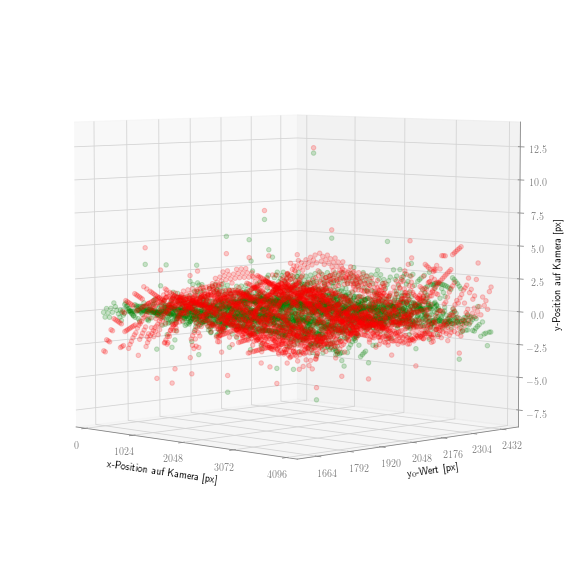

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection = '3d')

data_z32 = np.asanyarray(data_y) - polyval2d(data_x1, data_x2, popt32)
data_z22 = np.asanyarray(data_y) - polyval2d(data_x1, data_x2, popt22)
data_z23 = np.asanyarray(data_y) - polyval2d(data_x1, data_x2, popt23)
data_z33 = np.asanyarray(data_y) - polyval2d(data_x1, data_x2, popt33)

print('Mittlere quadratische Abweichung bei (3, 2): %f' % (data_z32**2).mean())
print('Mittlere quadratische Abweichung bei (2, 2): %f' % (data_z22**2).mean())
print('Mittlere quadratische Abweichung bei (2, 3): %f' % (data_z23**2).mean())
print('Mittlere quadratische Abweichung bei (3, 3): %f' % (data_z33**2).mean())

ax.set_xlabel('x-Position auf Kamera [px]')
ax.set_xticks(range(0, 4097, 1024))
ax.set_ylabel('y$_0$-Wert [px]')
ax.set_yticks(range(1792-128, 2305+128, 128))
ax.set_zlabel('y-Position auf Kamera [px]')
ax.scatter(data_x1, data_x2, data_z32, c='g', alpha=0.2)
ax.scatter(data_x1, data_x2, data_z22, c='r', alpha=0.2)
ax.view_init(elev=5, azim=-45)
plt.show()

Letztendlich soll das 2D-Polynom mehrere 1D-Polynome ersetzen. Dazu werden die zuvor gezeigten Datenpunkte (Zentren der Spektren) mit dem jeweiligen Polynom verglichen, das man mit $f(x,y_0)$ erhält.

Das Ergebnis ist etwas schlechter, als bei der Verwendung von unabhängigen Polynomen. Für die Korrektur ist jedoch die Funktionenschar notwendig, die außerdem alle Kurvenverläufe beschreibt, die wir nicht gemessen haben.

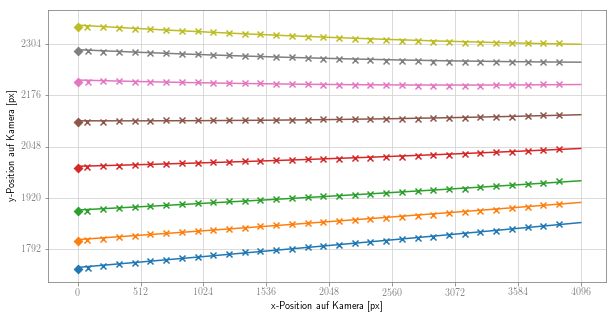

In [12]:
plt.figure(figsize=(10,5))
norm = mpl.colors.Normalize(vmin=0, vmax=len(files))
c_scale = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Vega10).to_rgba
for i, file in enumerate(files):
    for date in ('x-position',):
        plt.scatter(file['y-position'][0::4], file[date][0::4], c=c_scale(i), marker='x', linewidths=0.2)
        x_fit = np.linspace(0, 4097, 1000)
        y_fit = polyval2d(x_fit, file[date + '0'][0], popt23)
        plt.plot(x_fit, y_fit, c=c_scale(i))
        for val in set(file[date + '0']):
            plt.scatter(0, val, c=c_scale(i), marker='D', zorder=10)
plt.xticks(range(0, 4097, 512))
plt.xlabel('x-Position auf Kamera [px]')
plt.yticks(range(1792, 2305, 128))
plt.ylabel('y-Position auf Kamera [px]')
plt.savefig('Bilder/SR-EELS_Korrektur_Polynom2D_Position_1D')
plt.show()

Für äquidistante Werte von $y_0$ sind im folgenden Diagramm die rsultierenden Kurvenverläufe gezeigt.

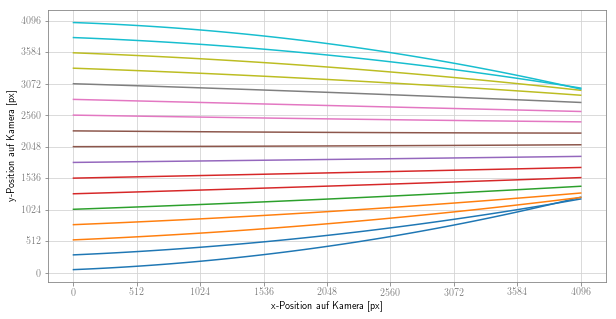

In [13]:
plt.figure(figsize=(10,5))
norm = mpl.colors.Normalize(vmin=0, vmax=4096)
c_scale = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Vega10).to_rgba
for i in range(0, 4097, 256):
    x_fit = np.linspace(0, 4097, 100)
    y_fit = polyval2d(x_fit, i, popt23)
    plt.plot(x_fit, y_fit, c=c_scale(i))
plt.xticks(range(0, 4097, 512))
plt.xlabel('x-Position auf Kamera [px]')
plt.yticks(range(0, 4097, 512))
plt.ylabel('y-Position auf Kamera [px]')
plt.show()

Als nächstes Wird die Veränderung der Spektrumsbreite betrachtet. uch diese lässt sich mit Hilfe eines 2D-Polynomes beschreiben.

An Hand der mittleren quadratischen Abweichung lässt sich erneut zeigen, welcher Grad des Polynoms am besten geeignet ist.

In [14]:
width_x1 = data['y-position']
width_x2 = data['x-position']
width_y = data['width']

popt_w22 = polyfit2d(width_x1, width_x2, width_y, (2, 2), fit_w=True)
popt_w32 = polyfit2d(width_x1, width_x2, width_y, (3, 2), fit_w=True)
popt_w23 = polyfit2d(width_x1, width_x2, width_y, (2, 3), fit_w=True)
popt_w33 = polyfit2d(width_x1, width_x2, width_y, (3, 3), fit_w=True)

width_z32 = np.asanyarray(width_y) - polyval2d(width_x1, width_x2, popt_w32, calc_w=True)
width_z22 = np.asanyarray(width_y) - polyval2d(width_x1, width_x2, popt_w22, calc_w=True)
width_z23 = np.asanyarray(width_y) - polyval2d(width_x1, width_x2, popt_w23, calc_w=True)
width_z33 = np.asanyarray(width_y) - polyval2d(width_x1, width_x2, popt_w33, calc_w=True)

print('Mittlere quadratische Abweichung bei (2, 2): %f' % (width_z22**2).mean())
print('Mittlere quadratische Abweichung bei (3, 2): %f' % (width_z32**2).mean())
print('Mittlere quadratische Abweichung bei (2, 3): %f' % (width_z23**2).mean())
print('Mittlere quadratische Abweichung bei (3, 3): %f' % (width_z33**2).mean())

Mittlere quadratische Abweichung bei (2, 2): 1.817229
Mittlere quadratische Abweichung bei (3, 2): 1.778677
Mittlere quadratische Abweichung bei (2, 3): 1.614286
Mittlere quadratische Abweichung bei (3, 3): 5436.035990


Als 3D-Plot erhält man folgendes Ergebnis:

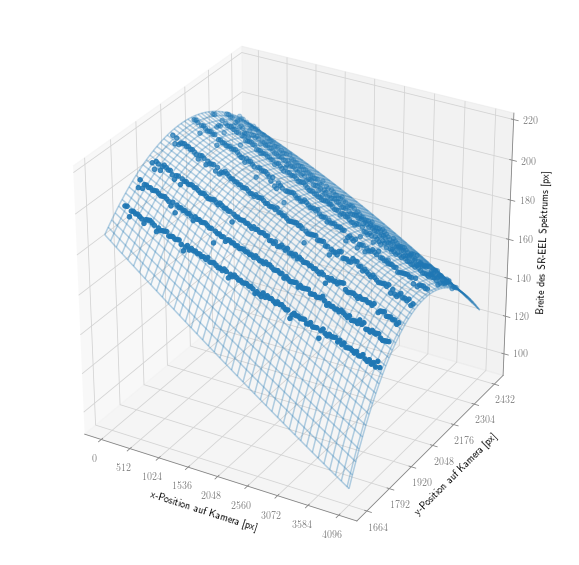

In [15]:
width_xs = np.linspace(0, 4097, 128)
width_ys = np.linspace(1792-128, 2305+128, 128)
width_Xs, width_Ys = np.meshgrid(width_xs, width_ys)
width_Zs = polyval2d(width_Xs, width_Ys, popt_w23, calc_w=True)


fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection = '3d')

ax.set_xlabel('x-Position auf Kamera [px]')
ax.set_xticks(range(0, 4097, 512))
ax.set_ylabel('y-Position auf Kamera [px]')
ax.set_yticks(range(1792-128, 2305+128, 128))
ax.set_zlabel('Breite des SR-EEL Spektrums [px]')
#ax.set_zticks(range(0, 201, 25))

ax.plot_wireframe(width_Xs, width_Ys, width_Zs, alpha=0.33)
ax.scatter(width_x1, width_x2, width_y)
#ax.view_init(azim=15)
plt.savefig('Bilder/SR-EELS_Korrektur_Polynom2D_Breite_3D')
plt.show()

Für die Korrektur wird nur die Kurve verwendet, an der das 2D-Polynom die y-x-Ebene schneidet.
Im folgenden Diagramm ist diese Kurve in grün geplottet.
Zum Vergleich werden die Schnitte für unterschiedliche Werte von x dargestellt. 

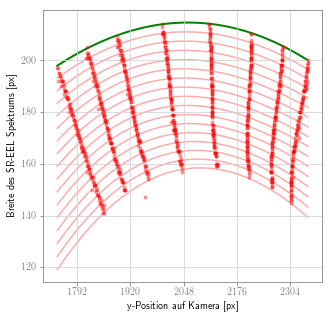

In [16]:
plt.figure(figsize=(5,5))
width_x = np.linspace(np.min(width_x2), np.max(width_x2), 1000)
width_0 = polyval2d(np.asanyarray((0,)*1000), width_x, popt_w23, calc_w=True)
plt.plot(width_x, width_0, c='g', lw=2, zorder=-1)
step = 256
for i in range(step, 4097, step):
    width_i = polyval2d(np.asanyarray((i,)*1000), width_x, popt_w23, calc_w=True)
    plt.plot(width_x, width_i, c='r', alpha=0.33, zorder=-2)
plt.scatter(width_x2, width_y, marker='.', c='r', alpha=0.33)
plt.xlabel('y-Position auf Kamera [px]')
plt.xticks(range(1792, 2305, 128))
plt.ylabel('Breite des SR-EEL Spektrums [px]')
plt.savefig('Bilder/SR-EELS_Korrektur_Polynom2D_Breite_1D')
plt.show()

Zu dem 1D-Polynom werden Maximum und Nullstellen bestimmt.
Damit kann die Funktion ``calc_y0`` erstellt werden, welche die Verzerrung der y-Achse wiedergibt.

In [17]:
func = lambda x: polyval2d(0, x, popt_w32, calc_w=True)
root_low = scipy.optimize.fsolve(func, 1792)
root_high = scipy.optimize.fsolve(func, 2304)
print(root_low, root_high)
x_max = scipy.optimize.fmin(lambda x: -func(x), 0)
func_n = lambda x: func(x) / func(x_max)

def calc_y0(x):
    return scipy.integrate.quad(func_n, x_max, x)[0] + x_max

y0_low = calc_y0(root_low)
y0_high = calc_y0(root_high)
calc_y0(1920)

[ 953.72101507] [ 3147.51882244]
Optimization terminated successfully.
         Current function value: -214.951071
         Iterations: 47
         Function evaluations: 94


array([ 1920.61741015])

Das folgende Diagramm gibt wieder, wie die y-Koordinaten nach $y_0$ transformiert werden.

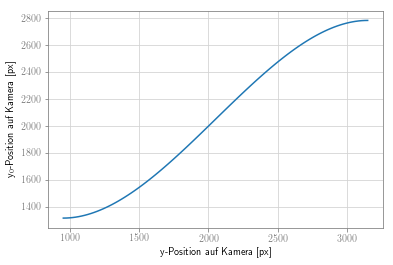

In [18]:
x_fit = np.linspace(root_low, root_high, 100)
#x_fit = np.linspace(0, 4096, 100)
y_fit = [calc_y0(val) for val in x_fit]
plt.plot(x_fit, y_fit)
plt.xlabel('y-Position auf Kamera [px]')
plt.ylabel('y$_0$-Position auf Kamera [px]')
plt.show()

Abschließend erhält man ein Diagramm, welches die Verzerrrung des Spektrums wiedergibt.
Zwischen den zuvor bestimmten Nullstellen wird y äquidistant varriiert.
Durch die große Anzahl von kurven kann mann die Verdichtung an den Nullstellen sehr gut nachvollziehen.

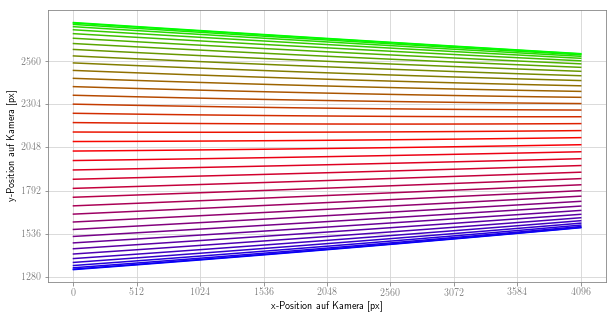

In [19]:
def multiple_of(a, b):
    return int((a // b) * b)

plt.figure(figsize=(10,5))
norm = mpl.colors.Normalize(vmin=root_low, vmax=root_high)
c_scale = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.brg).to_rgba
for i in np.linspace(root_low, root_high, 40):
    x_fit = np.linspace(0, 4097, 100)
    y_fit = polyval2d(x_fit, calc_y0(i), popt23)
    plt.plot(x_fit, y_fit, c=c_scale(i))
plt.xticks(range(0, 4097, 512))
plt.xlabel('x-Position auf Kamera [px]')
step = 256
plt.yticks(range(multiple_of(y0_low, step), multiple_of(y0_high, step)+1, step))
plt.ylabel('y-Position auf Kamera [px]')
plt.savefig('Bilder/SR-EELS_Korrektur_Kombination')
plt.show()

Die letzten Diagramme zeigen, was passiert, wenn man y-Werte verwendet, die außerhalb der der Nullstellen liegen.
Das Spektrum klappt nach innen.
Etwas ähliches lässt sich auch direkt am Mikroskop beobachten.

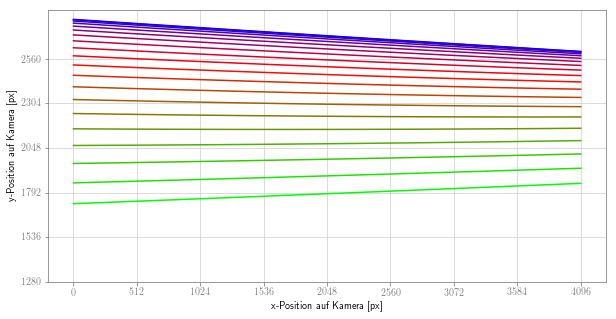

In [20]:
plt.figure(figsize=(10,5))
norm = mpl.colors.Normalize(vmin=root_high, vmax=4096)
c_scale = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.brg).to_rgba
for i in np.linspace(root_high, 4096, 20):
    x_fit = np.linspace(0, 4096, 100)
    y_fit = polyval2d(x_fit, calc_y0(i), popt23)
    plt.plot(x_fit, y_fit, c=c_scale(i))
plt.xticks(range(0, 4097, 512))
plt.xlabel('x-Position auf Kamera [px]')
step = 256
plt.yticks(range(multiple_of(y0_low, step), multiple_of(y0_high, step)+1, step))
plt.ylabel('y-Position auf Kamera [px]')
plt.show()

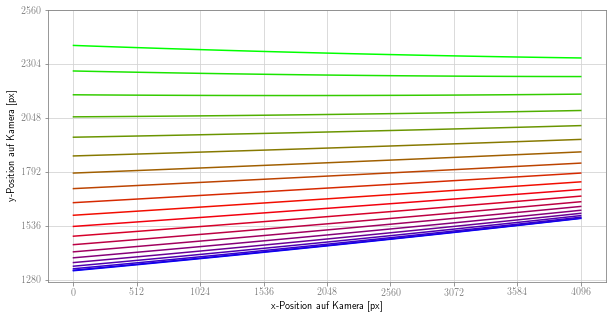

In [21]:
plt.figure(figsize=(10,5))
norm = mpl.colors.Normalize(vmin=0, vmax=root_low)
c_scale = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.brg_r).to_rgba
for i in np.linspace(root_low, 0, 20):
    x_fit = np.linspace(0, 4096, 100)
    y_fit = polyval2d(x_fit, calc_y0(i), popt23)
    plt.plot(x_fit, y_fit, c=c_scale(i))
plt.xticks(range(0, 4097, 512))
plt.xlabel('x-Position auf Kamera [px]')
step = 256
plt.yticks(range(multiple_of(y0_low, step), multiple_of(y0_high, step)+1, step))
plt.ylabel('y-Position auf Kamera [px]')
plt.show()